<a href="https://colab.research.google.com/github/hayatoy/tflite-examples/blob/master/TensorFlow_Lite_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download model, label and sample image

In [1]:
%%bash
export DATA_DIR="/tmp"
cd ${DATA_DIR}
curl -O https://raw.githubusercontent.com/google-coral/edgetpu/master/test_data/mobilenet_ssd_v2_coco_quant_postprocess.tflite
curl -O https://raw.githubusercontent.com/google-coral/edgetpu/master/test_data/coco_labels.txt
curl -O https://raw.githubusercontent.com/google-coral/edgetpu/master/test_data/pets.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6030k  100 6030k    0     0  8529k      0 --:--:-- --:--:-- --:--:-- 8517k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   930  100   930    0     0   6595      0 --:--:-- --:--:-- --:--:--  6595
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1018k  100 1018k    0     0  4009k      0 --:--:-- --:--:-- --:--:-- 4009k


In [2]:
!ls -la /tmp

total 7064
drwxrwxrwt 1 root root    4096 Jan 30 01:54 .
drwxr-xr-x 1 root root    4096 Jan 30 01:42 ..
-rw-r--r-- 1 root root     930 Jan 30 01:54 coco_labels.txt
-rw-r--r-- 1 root root 6175408 Jan 30 01:54 mobilenet_ssd_v2_coco_quant_postprocess.tflite
-rw-r--r-- 1 root root 1042820 Jan 30 01:54 pets.jpg


## Run inference

In [0]:
def set_input_tensor(interpreter, image):
  """Sets the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Returns the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor

In [4]:
import numpy as np
import tensorflow as tf
from PIL import Image

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/tmp/mobilenet_ssd_v2_coco_quant_postprocess.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Input image data
input_shape = input_details[0]['shape']
image = Image.open('/tmp/pets.jpg').convert('RGB').resize((input_shape[1], input_shape[2]), Image.ANTIALIAS)
set_input_tensor(interpreter, image)

# Run inference
interpreter.invoke()

# Get all output details
boxes = get_output_tensor(interpreter, 0)
classes = get_output_tensor(interpreter, 1)
scores = get_output_tensor(interpreter, 2)
count = int(get_output_tensor(interpreter, 3))

## Show results

In [5]:
print(boxes)
print(classes)
print(scores)

[[ 0.05031113  0.20842673  0.69200474  0.49746296]
 [ 0.3989889   0.64562154  0.8585544   0.958763  ]
 [ 0.38768953  0.456658    0.84725505  0.96945965]
 [ 0.15529113  0.2568253   0.52873325  0.44016632]
 [-0.00601101  0.01716727  0.2548468   0.4938339 ]
 [-0.0061523   0.00221827  0.14594534  0.47192016]
 [ 0.18141584  0.24269831  0.52854306  0.37957233]
 [ 0.04213233  0.06096328  0.2181644   0.713535  ]
 [ 0.23290156  0.22329424  0.6420601   0.36526155]
 [ 0.02709098  0.4329653   0.24287222  0.9976319 ]
 [ 0.00190531  0.07435658  0.23942956  0.98777866]
 [ 0.66205823  0.21097459  0.6773535   0.22519206]
 [ 0.28314862  0.28662726  0.643193    0.45396402]
 [ 0.3609352   0.28654876  0.4281065   0.3348967 ]
 [ 0.35295817  0.2683883   0.6584173   0.40526232]
 [ 0.08436218  0.71470535  0.10764477  0.7297237 ]
 [ 0.05695576  0.45162693  0.08200335  0.47249243]
 [ 0.08612708  0.6697526   0.10587987  0.682037  ]
 [ 0.57118714  0.20720355  0.5864824   0.22365831]
 [ 0.05777222  0.7265088   0.21

In [0]:
import re

def read_label_file(file_path):
  """Reads labels from text file and store it in a dict.
  This function supports following formats:
  1. Each line contains id and description separated by colon or space.
     Example: '0:cat' or '0 cat'.
  2. Each line contains description only. Label's id equals to row number.
  Args:
    file_path: String, path to the label file.
  Returns:
    Dict of (int, string) which maps label id to description.
  """
  with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()
  ret = {}
  for row_number, content in enumerate(lines):
    pair = re.split(r'[:\s]+', content.strip(), maxsplit=1)
    if len(pair) == 2 and pair[0].strip().isdigit():
      ret[int(pair[0])] = pair[1].strip()
    else:
      ret[row_number] = pair[0].strip()
  return ret

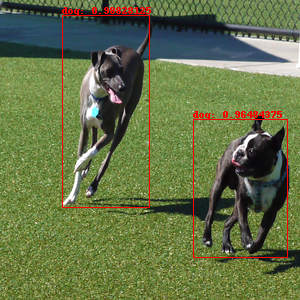

In [7]:
from PIL import Image, ImageDraw

classes_dict = read_label_file('/tmp/coco_labels.txt')

def highlight_objects(image, boxes, classes, scores):
  draw = ImageDraw.Draw(image, "RGBA")
  
  width = image.getbbox()[-2]
  height = image.getbbox()[-1]
  
  for ind, score in enumerate(scores):
    # show only results higher score than 0.7
    if score > 0.7:
      box = boxes[ind]
      n_vertex_lt = (box[1], box[0])
      n_vertex_rb = (box[3], box[2])

      vertex_lt = (int(n_vertex_lt[0] * width), int(n_vertex_lt[1] * height))
      vertex_rb = (int(n_vertex_rb[0] * width), int(n_vertex_rb[1] * height))
        
      # bounding box
      draw.rectangle(xy=(vertex_lt, vertex_rb), outline='red')
        
      # probability
      draw.text(xy=(vertex_lt[0], vertex_lt[1]-10),
                text="{}: {}".format(classes_dict[classes[ind]], str(score)),
                fill='red')    
  display(image)

highlight_objects(image, boxes, classes, scores)